In [1]:
%load_ext autoreload
%autoreload 2

# Readme
Change dataset, crop_id, obj_id only

# 1. Crop images

In [2]:
# load sam
from src.model.sam import CustomSamAutomaticMaskGenerator, load_sam
from segment_anything.modeling.sam import Sam
model_type = "vit_h"
checkpoint_dir =  "datasets/bop23_challenge/pretrained/segment-anything"
sam_model = load_sam(model_type, checkpoint_dir)
custom_sam_model = CustomSamAutomaticMaskGenerator(sam=sam_model)

In [3]:
def move_to_device(segmentor_model, device="cuda:0"):
    # if there is predictor in the model, move it to device
    if hasattr(segmentor_model, "predictor"):
        segmentor_model.predictor.model = (
            segmentor_model.predictor.model.to(device)
        )
    else:
        segmentor_model.model.setup_model(device=device, verbose=True)
move_to_device(custom_sam_model)

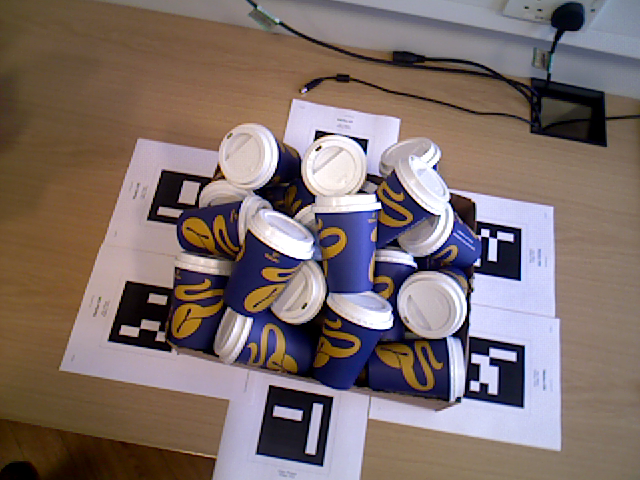

In [23]:
from PIL import Image
import torch
import numpy as np
from src.model.utils import Detections

dataset = "icbin"
# rgb_path = f"datasets/bop23_challenge/datasets/{dataset}/test/000050/rgb/001778.png"
rgb_path = "datasets/bop23_challenge/datasets/icbin/test/000001/rgb/000000.png" #"datasets/bop23_challenge/datasets/icbin/test/000001/rgb/000008.png"
rgb = Image.open(rgb_path).convert("RGB") # rotate(180)
detections = custom_sam_model.generate_masks(np.array(rgb))
rgb

In [24]:
def extract_object_by_mask(image, mask, width: int = 512):
    mask = Image.fromarray(mask)
    masked_image = Image.composite(
        image, Image.new("RGB", image.size, (0, 0, 0)), mask)
    cropped_image = masked_image.crop(masked_image.getbbox())
    # new_height = width * cropped_image.height // cropped_image.width
    return cropped_image

masked_images = []
for mask in detections["masks"].cpu():
    binary_mask = np.array(mask) * 255
    binary_mask = binary_mask.astype(np.uint8)
    masked_image = extract_object_by_mask(rgb, binary_mask)
    masked_images.append(masked_image)

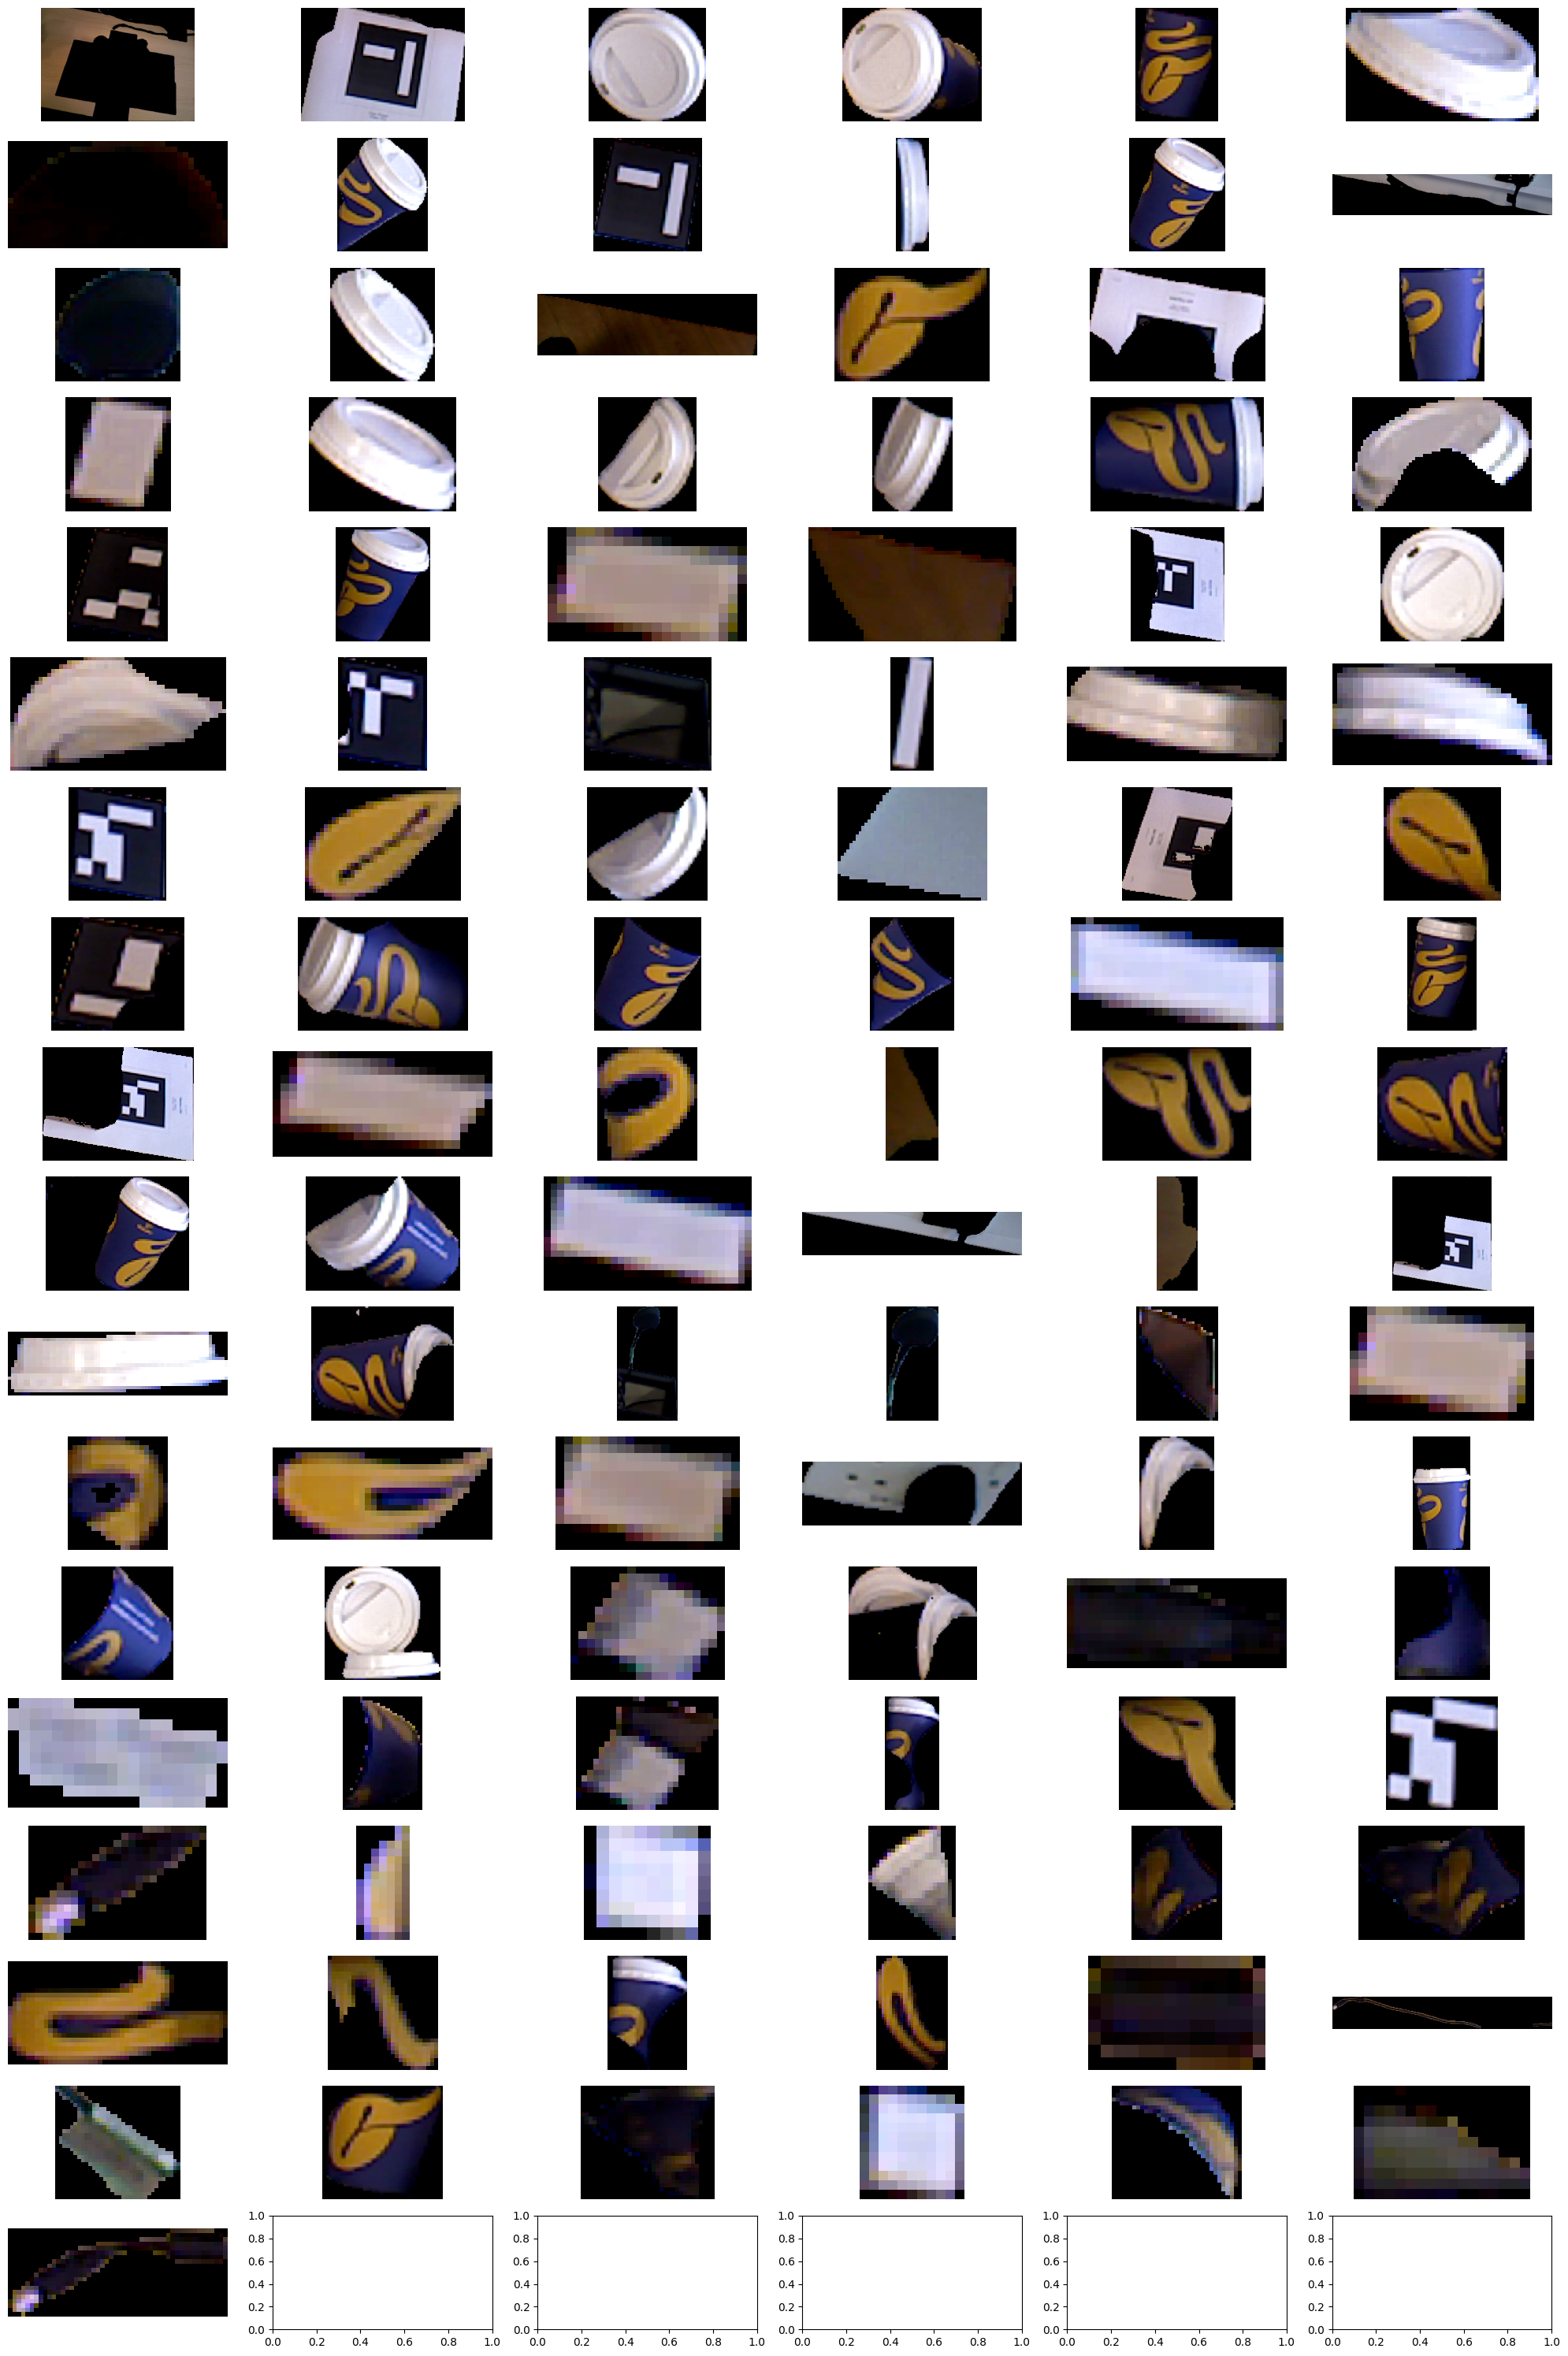

In [25]:
# Visualize proposals
import matplotlib.pyplot as plt
from math import ceil
def plot_images(images, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(20, 30))
    for i, ax in enumerate(axes.flat):
        if i >= len(images):
            break
        ax.imshow(images[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Define the number of rows and columns in the grid
rows = ceil(len(masked_images) / 6)
cols = 6
# Plot the masked_images array in a grid
plot_images(masked_images, rows, cols) 

In [26]:
import os

# Choose crop 4 it is in object id 12
crop_idx = 3
obj_id = 4
crop1 = {
    "crop" : masked_images[crop_idx], # it is saved as Image so crop1["crop"] to visualize it
    "masks" : detections["masks"][crop_idx],
    "boxes" : detections["boxes"][crop_idx]
}
# save image
if not os.path.exists(f"foundpose_analysis/{dataset}"):
    os.makedirs(f"foundpose_analysis/{dataset}")
crop1["crop"].save(f"foundpose_analysis/{dataset}/crop1.png")

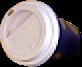

In [27]:
crop1["crop"]

# 2. Templates

## 2.1 Create templates of object

In [11]:
# # load config file
# import hydra
# from omegaconf import DictConfig, OmegaConf
# from hydra import initialize, compose

# # Initialize Hydra and compose the configuration
# initialize(config_path="configs")
# cfg = compose(config_name="run_inference")
# OmegaConf.set_struct(cfg, False)

/tmp/ipykernel_931597/531409554.py:7: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="configs")


In [12]:
# import os
# import glob

# default_ref_dataloader_config = cfg.data.reference_dataloader
# ref_dataloader_config = default_ref_dataloader_config.copy()
# ref_dataloader_config._target_ = "src.dataloader.bop_pbr.BOPTemplatePBR"
# ref_dataloader_config.root_dir = f"datasets/bop23_challenge/datasets/{dataset}"
# ref_dataloader_config.template_dir = " "

# level_template = 1 # Level 0 :42 templates, level 1, 162 templates
# data_type = "train_pbr" # test
# ref_dataloader_config.level_templates = level_template 
# ref_dataloader_config.split = data_type

# ply_files = glob.glob(f"datasets/bop23_challenge/datasets/{dataset}/models/*.ply")
# obj_ids = sorted([int(os.path.basename(obj_id)[8:10]) for obj_id in ply_files])
# ref_dataloader_config.obj_ids = obj_ids

# out_folder = f"foundpose_analysis/{dataset}/templates"
# if not os.path.exists(out_folder):
#     os.makedirs(out_folder)
# ref_dataloader_config.out_dir = out_folder
# ref_dataloader_config.templates_output_folder = f"{out_folder}/level_template_{level_template}"

In [19]:
# from hydra.utils import instantiate
# import os

# os.environ['HYDRA_FULL_ERROR'] = '1'
# ref_dataset = instantiate(ref_dataloader_config) # src.dataloader.bop.BOPTemplatePBR
# ref_dataset.load_processed_metaData(reset_metaData=True)

INFO:lightning_fabric.utilities.seed:Seed set to 2023
INFO:lightning_fabric.utilities.seed:Seed set to 2023
Loading metaData: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]
Finding nearest rendering close to template poses: 0it [00:00, ?it/s]


In [20]:
# from torchvision.utils import save_image
# import pandas as pd

# templates = pd.read_csv(f"{out_folder}/{ref_dataloader_config.split}_processed_metaData.csv")

# # Save templates as images
# for ob_id in range(len(obj_ids)): 
#     obj_id_path = os.path.join(f"{out_folder}/{ref_dataloader_config.split}_images_templates", f'obj_{(ob_id+1):06d}') # The transformed templates - check line 244, 245 in bop_pbr.py
#     original_obj_id_path = os.path.join(f"{out_folder}/{ref_dataloader_config.split}_images_templates", f'obj_{(ob_id+1):06d}_original')
    
#     if not os.path.exists(obj_id_path):
#         os.makedirs(obj_id_path)
#     if not os.path.exists(original_obj_id_path):
#         os.makedirs(original_obj_id_path)

#     try:  
#         for i, img in enumerate(ref_dataset[ob_id]["templates"]): # all the crop her is normalize and resize to 224*224 alsready in __getitem__
#             save_image(img, os.path.join(obj_id_path, f'{i:06d}.png'))
#         for i, img in enumerate(ref_dataset[ob_id]["original_templates"]): # all the crop her is normalize and resize to 224*224 alsready in __getitem__
#             save_image(img, os.path.join(original_obj_id_path, f'{i:06d}.png'))
#     except Exception as e:
#         print(f"An error occurred: {e}")

## 2.2. Patch descriptors register in 3D for templates

In [15]:
import glob
import os

# # Load original templates when before putting through dinov2 we also apply transfomation.
# template_path_1 = f"{out_folder}/{data_type}_images_templates/obj_{obj_id:06d}_original" 
# template_files_1= sorted(glob.glob(os.path.join(template_path_1, "*.png")), key=os.path.getmtime)

# obj_id_2 = 3
# template_path_2 = f"{out_folder}/{data_type}_images_templates/obj_{obj_id_2:06d}_original"
# template_files_2 = sorted(glob.glob(os.path.join(template_path_2, "*.png")), key=os.path.getmtime)

# obj_id_3 = 4
# template_path_3 = f"{out_folder}/{data_type}_images_templates/obj_{obj_id_3:06d}_original"
# template_files_3 = sorted(glob.glob(os.path.join(template_path_3, "*.png")), key=os.path.getmtime)

template_path_1 = "/home/cuong.vandam/Werkstudent_job/ren_luyen/do_an_tot_nghiep/ZS6D_template_rendering_old/output/ycbv/obj_obj_000004/" 
template_files_1= sorted(glob.glob(os.path.join(template_path_1, "*.png")), key=os.path.getmtime)

mask_paths = "/home/cuong.vandam/Werkstudent_job/ren_luyen/do_an_tot_nghiep/ZS6D_template_rendering_old/output/ycbv/obj_obj_000004/masks/" 
mask_files = sorted(glob.glob(os.path.join(mask_paths, "*.png")), key=os.path.getmtime)

template_files = template_files_1 
num_templates = len(template_files)
num_templates

0

In [16]:
from PIL import Image
import numpy as np
# [50:450, 150:500, :3]
templates = [np.array(Image.open(template_file).convert("RGB"))[ :, :, :3] for template_file in template_files] # This image has 4 channels- the last one is not crucial - maybe about opacity
masks = [np.array(Image.open(mask_file).convert("L")) for mask_file in mask_files] # This image has 4 channels- the last one is not crucial - maybe about opacity

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14_reg')
dinov2_vitl14.patch_size = 14
if torch.cuda.is_available():
    dinov2_vitl14 = torch.nn.DataParallel(dinov2_vitl14).to(device)  # Use DataParallel for multiple GPUs

Using cache found in /home/cuong.van-dam/.cache/torch/hub/facebookresearch_dinov2_main
/home/cuong.van-dam/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/cuong.van-dam/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/cuong.van-dam/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [18]:
from src.model.foundpose import (
    crop_feature_extraction, 
    kmeans_clustering, 
    calculate_templates_labels, 
    calculate_templates_vector,
    calculate_crop_vector,
    calculate_similarity,
    templates_feature_extraction,
    templates_feature_extraction_3
)


num_valid_patches, valid_patch_features = templates_feature_extraction_3(
    templates = templates, template_masks = masks, num_templates = num_templates, dino_model = dinov2_vitl14, device = device
    )

RuntimeError: torch.cat(): expected a non-empty list of Tensors

In [ ]:
valid_patch_features.shape

torch.Size([21396, 1024])

In [ ]:
sum(num_valid_patches)

21396

# Feature extraction for crop

In [ ]:
crop_rgb = np.array(Image.open(f"foundpose_analysis/{dataset}/crop1.png").convert("RGB")) # (124, 157, 3)

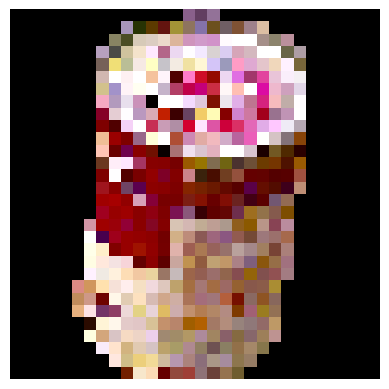

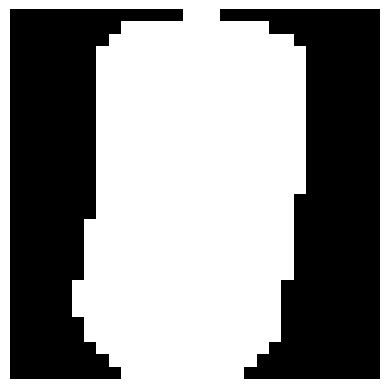

In [ ]:
from src.model.foundpose import (
    crop_feature_extraction_3
)

crop_num_valid_patches, valid_crop_feature_patches = crop_feature_extraction_3(crop_rgb = crop_rgb, dino_model = dinov2_vitl14, device = device)


# Stack all patch descriptors from both templates and crop and do pca

In [ ]:
valid_crop_feature_patches.shape[0]

468

In [ ]:
valid_patch_features.shape

torch.Size([21396, 1024])

In [ ]:
all_valid_patch_features = torch.cat((valid_crop_feature_patches.to('cpu'), valid_patch_features), dim=0)

In [ ]:
from sklearn.decomposition import PCA

# PCA
pca = PCA(n_components=256, random_state=5)
pca_crop_patches_descriptors = pca.fit_transform(np.array(all_valid_patch_features.cpu()))
print(pca_crop_patches_descriptors.shape)

(21864, 256)


In [ ]:
pca_crop = pca_crop_patches_descriptors[:valid_crop_feature_patches.shape[0]]
pca_templates = pca_crop_patches_descriptors[valid_crop_feature_patches.shape[0]:]

## 2.4 Perform Kmean clustering for all patch descriptors from templates (2048 clusters)

In [ ]:
kmeans = kmeans_clustering(pca_templates, ncentroids = 2048, niter = 20, verbose = True)

Clustering 21396 points in 256D to 2048 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
  Iteration 19 (0.08 s, search 0.06 s): objective=1.7961e+06 imbalance=1.267 nsplit=0        


WARNING clustering 21396 points to 2048 centroids: please provide at least 79872 training points


In [ ]:
templates_labels = calculate_templates_labels(num_valid_patches, kmeans, pca_templates)
templates_vector = calculate_templates_vector(templates_labels = templates_labels, num_clusters = 2048)

# 3. BoW descriptor for rgb crop

In [ ]:
# Assign labels to the data points
crop_labels = kmeans.index.search(pca_crop, 1)[1].reshape(-1)
crop_labels.shape

(468,)

In [ ]:
crop_vector = calculate_crop_vector(crop_labels = crop_labels, templates_labels = templates_labels, num_clusters = 2048)
concat_templates_vector = torch.cat([torch.tensor(vector).view(1,-1) for vector in templates_vector]) # Goal torch.Size([642, 2048])

In [ ]:
print(concat_templates_vector.shape)
print(crop_vector.shape)

torch.Size([642, 2048])
torch.Size([1, 2048])


# 4. Retrieve top similar pose

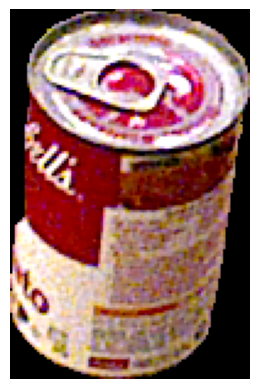

top 5 confidence scores tensor([[0.3624, 0.3332, 0.3301, 0.2999, 0.2579]], dtype=torch.float64)
final average confidence score tensor([0.3167], dtype=torch.float64)


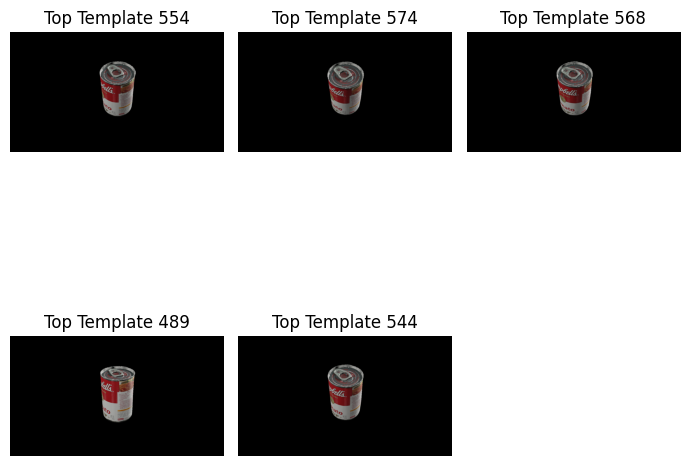

In [ ]:
# Compare crop to templates
from src.model.foundpose import calculate_similarity
calculate_similarity(crop_rgb, crop_vector, concat_templates_vector, templates, synthetic=True)